<a href="https://colab.research.google.com/github/LoTzuChin/113-1-FinancialBigData/blob/main/Forecast_10_days_later.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

[*********************100%***********************]  1 of 1 completed

Epoch 1/200



<ipython-input-17-6be7578a65ba>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].fillna(method='ffill')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0725
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102 
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028     
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024  
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014     
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0

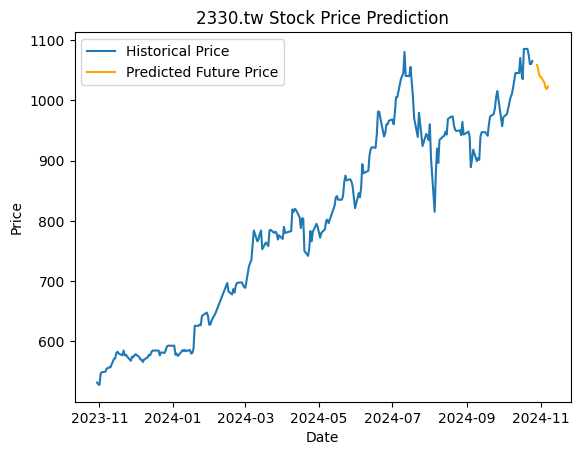

In [17]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 股票數據下載與準備
stock_id = '2330.tw'
end = dt.date.today()
start = end - dt.timedelta(days=365)  # 使用過去一年的資料
df = yf.download(stock_id, start=start, end=end).reset_index()

# 選擇收盤價進行預測
df['Close'] = df['Close'].fillna(method='ffill')
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# 設置參數
N = 10  # 預測未來10天的收盤價
window_size = 20  # 過去 M 日作為模型輸入

# 準備資料集
def create_dataset(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
    return np.array(X)

# 取出最後的 window_size 天資料作為預測輸入
X = create_dataset(df['Close'].values, window_size)
X_train = X  # 使用整個數據進行訓練

# 建立類神經網路模型
def build_tf_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(window_size,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

tf_model = build_tf_model()
tf_model.fit(X_train, df['Close'].values[window_size:], epochs=200, batch_size=16)

# 預測未來 10 天的股價
last_sequence = X[-1].reshape(1, -1)  # 用最後一段 window_size 的資料作為預測起點
predictions = []

for _ in range(N):
    pred = tf_model.predict(last_sequence)
    predictions.append(pred[0][0])
    last_sequence = np.append(last_sequence[:, 1:], pred).reshape(1, -1)  # 將預測結果加入下一次的輸入

# 將預測結果反轉回原始比例
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# 繪製結果
plt.plot(df['Date'], scaler.inverse_transform(df[['Close']]), label='Historical Price')
future_dates = pd.date_range(end + dt.timedelta(days=1), periods=N).to_pydatetime()
plt.plot(future_dates, predictions, label='Predicted Future Price', color='orange')
plt.legend()
plt.title(f"{stock_id} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()
